# Darcy flow in a 2D domain with varying permeability

$\mathrm{div}(-\frac{k}{\mu} \mathrm{grad}(p)) =0$

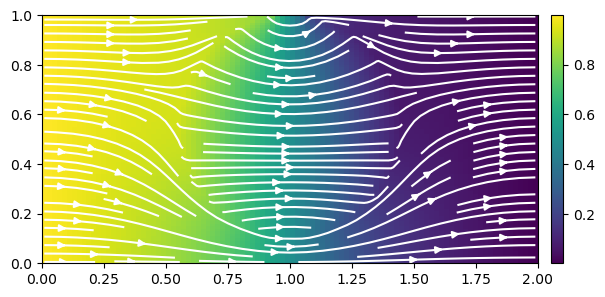

In [4]:
import math
import numpy as np
import scipy as sp
from scipy.sparse import linalg as sla
import matplotlib.pyplot as plt
from pymrm import construct_grad, construct_coefficient_matrix, construct_div, interp_stagg_to_cntr

# For ease of 2D plotting, and in accordance with ij indexing 
# of matrices where j is the x-direction, we here associate 
# x with dimension 1 and y with dimension 0

dim = 2
L = 1.0
cntr = [0.55*L, L]
R = 0.45*L
box = [L,2*L]
k_ext = 1
k_int = 0.05
mu = 1
shape_p = (100,100)

def permeability_field(x):
    x0 = x[0].reshape((-1,1))
    x1 = x[1].reshape((1,-1))
    k = k_ext + (k_int-k_ext)*(((x0-cntr[0])*(x0-cntr[0])+(x1-cntr[1])*(x1-cntr[1]))<R*R)
    return k

x_f = [None] * dim
x_c = [None] * dim
for i in range(dim):
    x_f[i] = np.linspace(0,box[i], shape_p[i]+1)
    x_c[i] = 0.5*(x_f[i][1:]+x_f[i][:-1])

bc = [None]*dim
bc[0] = ({'a': 1, 'b': 0, 'd':0},)*2
bc[1] = ({'a': 0, 'b': 1, 'd':1},{'a': 0, 'b': 1, 'd':0}) 

# permeabilities at face positions
k_f = [None]*dim
k_f[0] = permeability_field((x_f[0], x_c[1]))
k_f[1] = permeability_field((x_c[0], x_f[1]))

Flux = [None]*dim
flux_bc = [None]*dim
Lapl = sp.sparse.csc_array((math.prod(shape_p),math.prod(shape_p)))
lapl_bc = np.zeros((math.prod(shape_p),1))
for i in range(dim):
    Grad, grad_bc = construct_grad(shape_p, x_f[i], x_c[i], bc[i], axis=i)
    K = construct_coefficient_matrix(k_f[i]/mu)
    Flux[i] = -K @ Grad
    flux_bc[i] = - K @ grad_bc
    Div = construct_div(shape_p, x_f[i], nu=0, axis=i)
    Lapl += Div @ Flux[i]
    lapl_bc += Div @ flux_bc[i]
Lapl_lu = sla.splu(Lapl)
p = -Lapl_lu.solve(lapl_bc).reshape(shape_p)

flux_c = [None]*dim
for i in range(dim):
    shape_f = list(shape_p)
    shape_f[i] +=1
    flux = (Flux[i]@p.reshape((-1,1))+flux_bc[i]).reshape(shape_f)
    flux_c[i] = interp_stagg_to_cntr(flux, x_f[i], x_c[i], axis=i)

fig, ax = plt.subplots()
contour = ax.pcolormesh(x_f[1], x_f[0], p, shading='flat', cmap='viridis')
X,Y = np.meshgrid(x_c[1], x_c[0],indexing='xy')
ax.streamplot(X, Y, flux_c[1], flux_c[0], color = 'white')
ax.set_xlim(x_f[1][0], x_f[1][-1])
ax.set_ylim(x_f[0][0], x_f[0][-1])
ax.set_aspect('equal')
cbar_ax = fig.add_axes([0.92, ax.get_position().y0, 0.02, ax.get_position().y1-ax.get_position().y0])  # Adjust the parameters as needed [left, bottom, width, height]
plt.colorbar(contour, cax=cbar_ax)
plt.show()